In [14]:
%load_ext autoreload
%autoreload 2
from funcs import readin, show_adj_matrix, obj_function, adjmatrix2adjmap
import numpy as np

from itertools import chain

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [15]:
S, A, W = readin('data/test1.txt')
N = A.shape[0]
A1 = np.zeros(A.shape)


In [16]:
import networkx as nx

G = nx.from_numpy_array(A)
for g in nx.connected_components(G):
    print(A[list(g)])

[[0 1 0 1 0 0 0 0 0]
 [1 0 1 0 0 0 0 0 0]
 [0 1 0 1 1 0 0 0 0]
 [1 0 1 0 1 0 0 0 0]
 [0 0 1 1 0 1 1 0 0]
 [0 0 0 0 1 0 1 1 0]
 [0 0 0 0 1 1 0 0 1]
 [0 0 0 0 0 1 0 0 1]
 [0 0 0 0 0 0 1 1 0]]


In [17]:
def is_splex( A: np.ndarray,  s: int) -> bool:
    G = nx.from_numpy_array(A)

    for cc in nx.connected_components(G):
        if not is_splex_component(cc, s, A):
            return False
        
    return True


def is_splex_component(component : set, s: int, A: np.ndarray = A):
    component = list(component)
    neighbor_degrees = A[component].sum(axis=1)
    return (neighbor_degrees >= neighbor_degrees.shape[0] - s).sum() > 0 
    
is_splex(A, 3)

False

In [66]:

class GreedySPlex:
    TERROR_VALUE = 99999
    def __init__(self, adjacency_matrix : np.ndarray, weight_matrix: np.ndarray, s: int):
        self.A = adjacency_matrix
        self.W = weight_matrix.copy()
        np.fill_diagonal(self.W, GreedySPlex.TERROR_VALUE)
        self.W[adjacency_matrix==1] *= -1
        self.s = s 
        self.weightmap = adjmatrix2adjmap(self.W)

    def solution(self):
        splexes = {i:{i} for i in range(self.A.shape[0])}
        A1 = np.zeros(self.A.shape, dtype=int)
        # We start with the graph with all edges removed
        # and we try to add them back one at a time (sorted by weight)
        edges_by_weight = sorted([e for e in self.weightmap.keys() if self.weightmap[e]<0], key=self.weightmap.get)

        for i,j in edges_by_weight:
            s_i = splexes[i]
            s_j = splexes[j]
            plex_size = len(s_i) + len(s_j)
            
            if s_i is s_j or plex_size <= (S+1):
                # if they are less than S+1 they are always a legit s-plex
                self.merge(i,j,splexes, A1)
                continue

            cost = 0
            added_edges = dict()
            candidate_splex = list(chain(s_i, s_j))

            # We now try to see if merging the 2 splexes is convenient or not
            # For each of the nodes we check how many edges we need to add to make it a valid splex
            # we then add the "less expensive" edges
            # if the operation is convinient we perform it, otherwise we abort it

            W1 = self.W.copy()
            # in order to constrain our choice of edges to only those in the considered splexes,
            # We're going to use a Terror_Value (very high number) to make the algorithm pick only the desired edges

            # set the weights of candidate plex to very low value in order to make the algorithm choose that
            W1[np.ix_(candidate_splex, candidate_splex)] -= GreedySPlex.TERROR_VALUE
            # W1[list(s_j), list(s_i)] -= GreedySPlex.TERROR_VALUE
            # set the weights of already present edges to terror value
            W1[A1 == 1] = GreedySPlex.TERROR_VALUE
            np.fill_diagonal(W1, GreedySPlex.TERROR_VALUE)

            for k in candidate_splex:
                missing_edges = plex_size - self.s - A1[k].sum()
                weights = W1[k]
                nodes = np.argpartition(weights, missing_edges)[:missing_edges+1]

                added_edges[k] = nodes
                cost += self.W[k,nodes].sum()
                W1[k,nodes] = GreedySPlex.TERROR_VALUE
                W1[nodes,k] = GreedySPlex.TERROR_VALUE

            # if the computed cost indicates that there's a gain
            if cost < 0:
                self.merge(i,j,splexes, A1, added_edges)

        return A1, splexes
    
    def merge(self, i: int, j: int, splexes: dict, A1: np.ndarray, added_edges : dict = None):
        # Set edge
        A1[i,j] = 1
        A1.T[i,j] = 1
        # Merge splexes
        if splexes[i] is not splexes[j]:
            splexes[i] = splexes[i] | splexes[j] # union
            for k in splexes[i]:
                splexes[k] = splexes[i]

                if added_edges is not None:
                    A1[k, added_edges[k]] = 1
                    A1[added_edges[k], k] = 1

solver = GreedySPlex(A,W,S)
A1, splexes = solver.solution()
splexes

[0, 1, 2, 3, 4] [[  99999   99999  -99993 -100000  -99990      10       1       1       1]
 [  99999   99999 -100001  -99995  -99993       1       1       1       1]
 [ -99993 -100001   99999   99999 -100000       4       2       1       1]
 [-100000  -99995   99999   99999   99999       4       3       1       1]
 [ -99990  -99993 -100000   99999   99999      -1      -1       3       3]
 [     10       1       4       4      -1   99999      -1      -1       2]
 [      1       1       2       3      -1      -1   99999       1      -1]
 [      1       1       1       1       3      -1       1   99999      -1]
 [      1       1       1       1       3       2      -1      -1   99999]]
[0, 1, 2, 3, 4] [[  99999   99999  -99993 -100000  -99990      10       1       1       1]
 [  99999   99999 -100001  -99995  -99993       1       1       1       1]
 [ -99993 -100001   99999   99999 -100000       4       2       1       1]
 [-100000  -99995   99999   99999   99999       4       3       1  

{0: {0, 1},
 1: {0, 1},
 2: {2, 3, 4},
 3: {2, 3, 4},
 4: {2, 3, 4},
 5: {5, 6, 7},
 6: {5, 6, 7},
 7: {5, 6, 7},
 8: {8}}

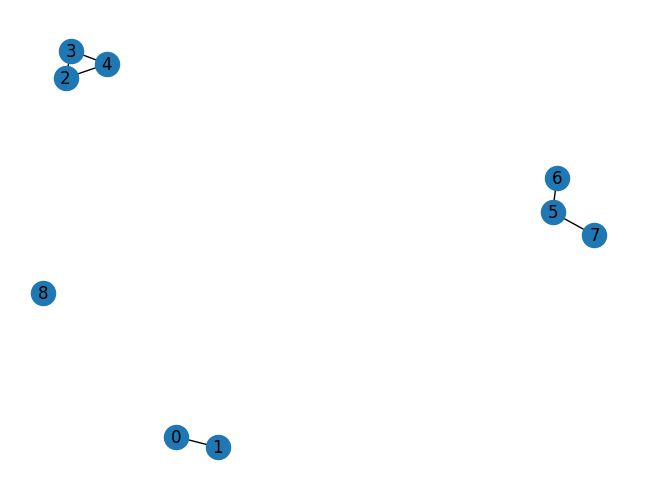

14

In [67]:
show_adj_matrix(A1)
obj_function(A,A1,W)